# Abuzer-Nezerov-116

### importing every library for work

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, learning_curve, KFold, cross_val_score
import warningsD

In [2]:
# disabling warnings
warnings.filterwarnings('ignore')

# showing max columns and setting width option to 1000
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
path = Path("../data")

# Regression

### initial thing to do for selecting data and additional setup

In [3]:
# loading data
cars_path = path / "cars.csv"
data = pd.read_csv(cars_path)

In [4]:
data.describe()

,price_x,production_year,engine_displacement_num,kilometrage_num,price_y,phone,views,Buraxılış ili
count,653721.000000,653721.000000,653721.000000,6.537210e+05,653721.000000,6.534560e+05,653721.000000,653721.000000
mean,31630.966437,1995.886897,2.221417,1.565231e+05,31630.917933,5.589415e+08,3740.731827,2013.797752
std,28679.360855,188.793547,1.266334,1.458949e+05,28679.394420,1.516718e+08,10299.032842,7.646318
min,500.000000,0.000000,0.000000,0.000000e+00,500.000000,7.800000e+01,12.000000,1938.000000
25%,16800.000000,2009.000000,1.600000,5.502200e+04,16800.000000,5.060014e+08,432.000000,2009.000000
50%,25300.000000,2015.000000,2.000000,1.450000e+05,25300.000000,5.524029e+08,1367.000000,2015.000000
75%,36800.000000,2019.000000,2.500000,2.223330e+05,36800.000000,5.588827e+08,3412.000000,2019.000000
max,940000.000000,2024.000000,120.000000,9.900025e+06,940000.000000,9.999997e+08,359317.000000,2024.000000


In [5]:
data = data.sample(50_000) # selecting 50_000 samples from data

In [6]:
# removing every duplicate value from dataset
data.drop_duplicates(subset=["car_rel_url_x"], inplace=True, keep="last")
data.duplicated().sum()

np.int64(0)

In [7]:
currencies =  list(set(data["currency_x"])) # listing all of the available currencies

# # values of which in currency of euro has missing values I will drop them
# data[data["price_x"].isna()] # only three of them is NA the in currency euro
# data = data.dropna(subset="price_x", how="all")

# I will replace all of the nan with mode beacuse of I did think mode will fit for this type of the column
data["Yerlərin sayı"].fillna(data["Yerlərin sayı"].mode()[0], inplace=True)

data["price_x"] =  data["price_x"].astype("int")

# parsing "Mühərrik" to two categories hourse power (a.g) and Fuel
engine_parsed = data["Mühərrik"].str.split("/", expand=True)
engine_parsed_new = pd.DataFrame(np.where((engine_parsed.iloc[::, -2] == " Elektro"), engine_parsed[0], engine_parsed[1]), index=data["Mühərrik"].index)
data["Hourse Power"] = engine_parsed_new[0].str.split("a.g.", expand=True)[0]
data = data.drop(data.loc[data["Hourse Power"].isna()].index)
data["Hourse Power"] = data["Hourse Power"].astype("int")

data["Fuel"] = engine_parsed[2]

data["currency_x"].value_counts() # listing all of the available currencies ['€', '$', 'AZN']

# I convert the currency to AZN cause I don't want to misunderstunding in model
dollar = data.loc[data["currency_x"] == "$", "price_x"]
euro = data.loc[data["currency_x"] == "€", "price_x"]

data.loc[data["currency_x"] == "$", "price_x"] = dollar * 1.7
data.loc[data["currency_x"] == "€", "price_x"] = euro * 1.8

### Selecting required columns

In [92]:
df = data[["Sürətlər qutusu","production_year", "engine_displacement_num", "Hourse Power", "Fuel", "kilometrage_num", "Yerlərin sayı", "price_x", "Yeni"]]

In [93]:
df

,Sürətlər qutusu,production_year,engine_displacement_num,Hourse Power,Fuel,kilometrage_num,Yerlərin sayı,price_x,Yeni
296361,Mexaniki,1997,1.5,75,Benzin,500000,5,2100.0,Xeyr
329611,Avtomat,1996,2.0,116,Benzin,302000,5,4300.0,Xeyr
209140,Avtomat,2015,2.0,190,Dizel,197000,5,33000.0,Xeyr
477691,Avtomat,2008,3.0,188,Benzin,210000,7,19500.0,Xeyr
304731,Avtomat,2015,2.0,145,Benzin,163500,5,25750.0,Xeyr
...,...,...,...,...,...,...,...,...,...
30707,Avtomat,2016,3.0,306,Dizel,121000,5,75650.0,Xeyr
182406,Avtomat,2010,5.0,510,Benzin,163000,5,49000.0,Xeyr
263729,Avtomat,2015,2.0,190,Dizel,163645,5,32900.0,Xeyr
553036,Mexaniki,2008,2.2,116,Dizel,275200,8+,25500.0,Xeyr


In [ ]:
le = LabelEncoder()
one_encode = OneHotEncoder(sparse_output=False)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 2510.  ,  3052.44,  3594.88,  4137.32,  4679.76,  5222.2 ,
         5764.64,  6307.08,  6849.52,  7391.96,  7934.4 ,  8476.84,
         9019.28,  9561.72, 10104.16, 10646.6 , 11189.04, 11731.48,
        12273.92, 12816.36, 13358.8 , 13901.24, 14443.68, 14986.12,
        15528.56, 16071.  , 16613.44, 17155.88, 17698.32, 18240.76,
        18783.2 , 19325.64, 19868.08, 20410.52, 20952.96, 21495.4 ,
        22037.84, 22580.28, 23122.72, 23665.16, 24207.6 , 24750.04,
        25292.48, 25834.92, 26377.36, 26919.8 , 27462.24, 28004.68,
        28547.12, 29089.56, 29632.  ]),
 <BarContainer object of 50 artists>)

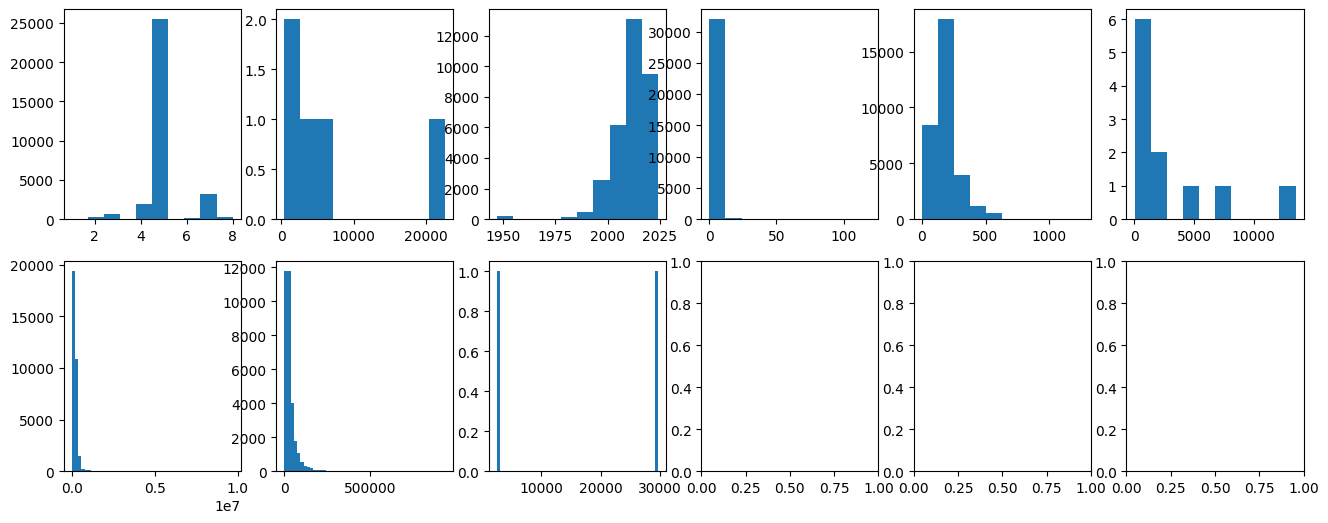

In [86]:
_, axes = plt.subplots(2, 6, figsize=(16, 6))

df.loc[df["production_year"] == 0, "production_year"] = 1954
df.loc[df["Yerlərin sayı"]=="8+", "Yerlərin sayı"] = 8
df["Yerlərin sayı"] = df["Yerlərin sayı"].astype("int")
df.loc[df["production_year"] == 0, "production_year"] = 1954



axes[0][0].hist(df["Yerlərin sayı"])
axes[0][1].hist(df["Sürətlər qutusu"].value_counts())
axes[0][2].hist(df["production_year"])
axes[0][3].hist(df["engine_displacement_num"])
axes[0][4].hist(df["Hourse Power"])
axes[0][5].hist(df["Fuel"].value_counts())
axes[1][0].hist(df["kilometrage_num"], range=(df["kilometrage_num"].min(), df["kilometrage_num"].max()), bins=50)
axes[1][1].hist(df["price_x"], bins=50)
axes[1][2].hist(df["Yeni"].value_counts(), bins=50)


Sürətlər qutusu
Avtomat     22709
Mexaniki     5614
Variator     2674
Reduktor      754
Robot         391
Name: count, dtype: int64

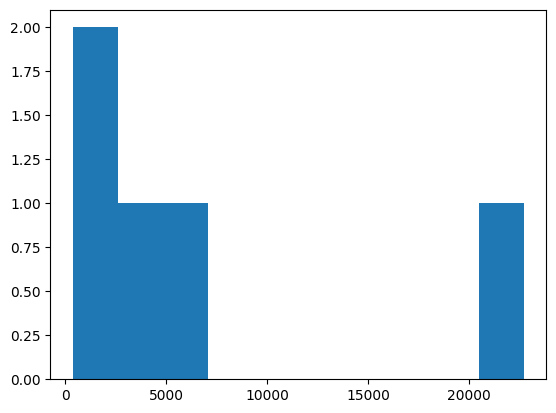

### Encoding categories

In [94]:

le = LabelEncoder()
one_encode = OneHotEncoder(sparse_output=False)


# encodign categories in "Sürətlər qutusu" and "Fuel"
encoded_future1 = one_encode.fit_transform(df["Sürətlər qutusu"].to_numpy().reshape(-1,1))
encoded_future1 = pd.DataFrame(encoded_future1, columns=one_encode.get_feature_names_out(["Sürətlər qutusu"]), index=df["Sürətlər qutusu"].index)
df = pd.concat([encoded_future1, df], axis=1)
df.drop("Sürətlər qutusu", axis=1, inplace=True)

encoded_future2 = one_encode.fit_transform(df["Fuel"].to_numpy().reshape(-1,1))
encoded_future2 = pd.DataFrame(encoded_future1, columns=one_encode.get_feature_names_out(["Fuel"]), index=df["Fuel"].index)
df = pd.concat([encoded_future1, df], axis=1)
df.drop("Fuel", axis=1, inplace=True)

# Will be replace the values "Xeyr" and "Beli" to 0 and 1 with labelEncoder
df["Yeni"] = le.fit_transform(df["Yeni"])

# cause of the 8+ giving all of the dataset as object I need to change it and additonaly minimum value set 0 and need to change it too
df.loc[df["production_year"] == 0, "production_year"] = 1954
df.loc[df["Yerlərin sayı"]=="8+", "Yerlərin sayı"] = 8
df["Yerlərin sayı"] = df["Yerlərin sayı"].astype("int")


scalar = MinMaxScaler()
scale = StandardScaler()
# futures = ["production_year", "engine_displacement_num", "Hourse Power", "kilometrage_num", "Yerlərin sayı"]
# df[futures] = scalar.fit_transform(df[futures])



In [95]:
df

,Sürətlər qutusu_Avtomat,Sürətlər qutusu_Mexaniki,Sürətlər qutusu_Reduktor,Sürətlər qutusu_Robot,Sürətlər qutusu_Variator,Sürətlər qutusu_Avtomat,Sürətlər qutusu_Mexaniki,Sürətlər qutusu_Reduktor,Sürətlər qutusu_Robot,Sürətlər qutusu_Variator,production_year,engine_displacement_num,Hourse Power,kilometrage_num,Yerlərin sayı,price_x,Yeni
296361,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1997,1.5,75,500000,5,2100.0,1
329611,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1996,2.0,116,302000,5,4300.0,1
209140,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2015,2.0,190,197000,5,33000.0,1
477691,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2008,3.0,188,210000,7,19500.0,1
304731,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2015,2.0,145,163500,5,25750.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30707,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2016,3.0,306,121000,5,75650.0,1
182406,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2010,5.0,510,163000,5,49000.0,1
263729,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2015,2.0,190,163645,5,32900.0,1
553036,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2008,2.2,116,275200,8,25500.0,1


In [97]:
futures = ["production_year", "engine_displacement_num", "Hourse Power", "kilometrage_num",]
df[futures] = scalar.fit_transform(df[futures])
df[["Yerlərin sayı"]] = scale.fit_transform(df[["Yerlərin sayı"]])

In [98]:
df

,Sürətlər qutusu_Avtomat,Sürətlər qutusu_Mexaniki,Sürətlər qutusu_Reduktor,Sürətlər qutusu_Robot,Sürətlər qutusu_Variator,Sürətlər qutusu_Avtomat,Sürətlər qutusu_Mexaniki,Sürətlər qutusu_Reduktor,Sürətlər qutusu_Robot,Sürətlər qutusu_Variator,production_year,engine_displacement_num,Hourse Power,kilometrage_num,Yerlərin sayı,price_x,Yeni
296361,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.649351,0.012500,0.058544,0.051539,-0.103912,2100.0,1
329611,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.636364,0.016667,0.090981,0.031129,-0.103912,4300.0,1
209140,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.883117,0.016667,0.149525,0.020306,-0.103912,33000.0,1
477691,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.792208,0.025000,0.147943,0.021646,2.239086,19500.0,1
304731,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.883117,0.016667,0.113924,0.016853,-0.103912,25750.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30707,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.896104,0.025000,0.241297,0.012472,-0.103912,75650.0,1
182406,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.818182,0.041667,0.402690,0.016802,-0.103912,49000.0,1
263729,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.883117,0.016667,0.149525,0.016868,-0.103912,32900.0,1
553036,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.792208,0.018333,0.090981,0.028367,3.410585,25500.0,1


### Splitting Data into two set and Applying mainfold

In [99]:
# spilliting data to two set
X = df.drop("price_x", axis=1)
y = df["price_x"].to_numpy()

In [67]:
from sklearn.preprocessing import PolynomialFeatures

X = PolynomialFeatures(degree=2).fit_transform(X)


### Showing Correlations between data

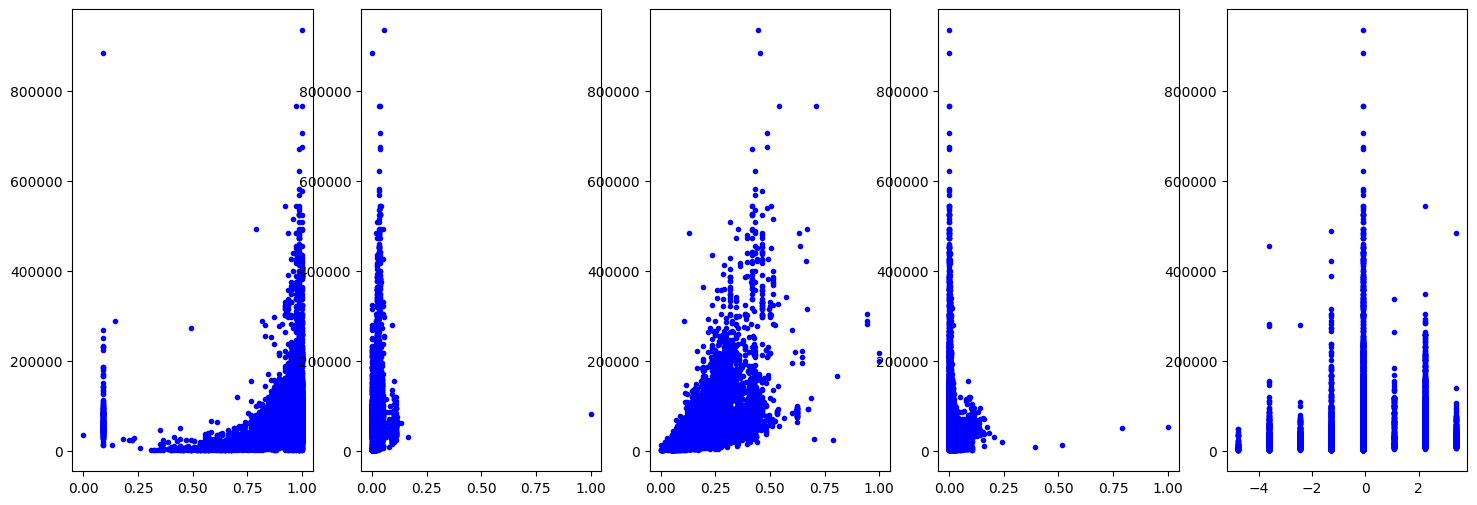

In [110]:
_, axes= plt.subplots(1, 5, figsize=(18,6))


axes[0].ticklabel_format(style='plain', axis='both') 
axes[0].plot(X["production_year"],y, "b.")
axes[1].plot(X["engine_displacement_num"],y, "b.")
axes[2].plot(X["Hourse Power"],y, "b.")
axes[3].plot(X["kilometrage_num"],y, "b.", scaley=True)
axes[4].plot(X["Yerlərin sayı"],y, "b.", scaley=True)

### Creating Traning and Test dataset

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

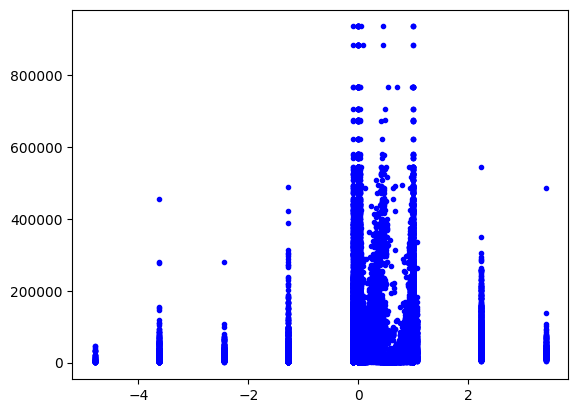

In [103]:
plt.plot(X, y, 'b.')

## Creating Model

### Baseline Model

In [104]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

In [105]:
### Testing metrices for this model
mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)

(947964945.2343057, 14846.255077273285)

In [106]:
r2_score(y_test, y_pred)

0.46624349579685975

### Best Performed Model

In [107]:
from sklearn.ensemble import RandomForestRegressor
rnd_clf = RandomForestRegressor(n_estimators=100, max_leaf_nodes=80, n_jobs=-1, random_state=42,oob_score=True)
rnd_clf.fit(X_train, y_train)

y_pred_f = rnd_clf.predict(X_test)

In [108]:
mean_squared_error(y_test, y_pred_f), mean_absolute_error(y_test, y_pred_f)

(329717610.01281893, 7737.212391820289)

In [109]:
from sklearn.model_selection import cross_val_score
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

cross_val_score(rnd_clf,X_train, y_train, scoring="r2", cv=folds)

array([0.87709982, 0.88243834, 0.8758236 , 0.87536721, 0.84244727])

# Clasification

## Loading Data and Overlooking 

In [4]:
# loading data
path = Path("../data")
house_path = path / "house_sale.csv"
data = pd.read_csv(house_path)

In [7]:
data.head()

,id_x,rel_url,estate_rel_url_x,datetime_scrape_x,price,currency_x,location,attributes,city_when,city,day_x,hour_x,repair,vip,featured,products_label,bill_of_sale,mortgage,img_url,id_y,estate_id,estate_rel_url_y,datetime_scrape_y,description,unit_price,total_price,currency_y,owner_name,owner_title,shop_name,shop_title,address,lat,lng,updated,views,day_y,hour_y,estate_details_id_x,Binanın növü,Kateqoriya,Mərtəbə,Otaq sayı,Sahə,Torpaq sahəsi,Təmir,Çıxarış,İpoteka,estate_details_id_y,estate_rel_url,extra_info
0,5df36281-6dc6-4d5d-89a7-5fcfa86f7608,/alqi-satqi?page=174,/items/4521724,2024-10-05 22:07:37.60613+00,499999.0,AZN,Səbail r.,"4 otaqlı, 145 m², 7/9 mərtəbə","Bakı, dünən 23:52",bakı,05.10.2024,23:52,Təmirli,vipped,featured,NaN,Çıxarış var,NaN,https://bina.azstatic.com/uploads/f460x345/202...,92e82ea2-e1f3-4c2d-a284-151efd99281e,5df36281-6dc6-4d5d-89a7-5fcfa86f7608,/items/4521724,2024-10-05 22:14:10.089116+00,"Səbail Rayonu, İzzət Nəbiyev küçəsi, Fəxri Xiy...",3 450 AZN/m²,499999.0,AZN,Kamran,mülkiyyətçi,NaN,NaN,İzzət Nəbiyev küç.,40.358817,49.824092,yeniləndi: dünən 23:52,1155,05.10.2024,23:52,92e82ea2-e1f3-4c2d-a284-151efd99281e,NaN,Köhnə tikili,7 / 9,4.0,145 m²,NaN,var,var,NaN,92e82ea2-e1f3-4c2d-a284-151efd99281e,/items/4521724,Şəhidlər xiyabanı * Dağüstü parkı * Səbail r.
1,883e20f0-8872-49a5-8b4b-63b8301b5f8f,/alqi-satqi?page=250,/items/4669294,2024-10-05 22:07:37.60613+00,77000.0,AZN,Biləcəri q.,"4 otaqlı, 90 m²","Bakı, dünən 23:56",bakı,05.10.2024,23:56,Təmirli,NaN,NaN,NaN,NaN,NaN,https://bina.azstatic.com/uploads/f460x345/202...,505eaf81-6bc8-4094-9b00-aa82066548ee,883e20f0-8872-49a5-8b4b-63b8301b5f8f,/items/4669294,2024-10-05 22:14:10.089116+00,"Biləcəridə Abidəyə yaxin 91,92,202 saylı marşr...",NaN,77000.0,AZN,Dasinmaz Emlak,vasitəçi (agent),NaN,NaN,Biləcəri qəs.,40.420897,49.807035,yeniləndi: 04 oktyabr 2024,218,04.10.2024,NaN,505eaf81-6bc8-4094-9b00-aa82066548ee,NaN,Həyət evi/Bağ evi,NaN,4.0,90 m²,1.3 sot,var,yoxdur,NaN,505eaf81-6bc8-4094-9b00-aa82066548ee,/items/4669294,Binəqədi r.* Biləcəri q.
2,55c36fb1-a3af-476e-ba17-a81f6795be8d,/alqi-satqi?page=250,/items/4669293,2024-10-05 22:07:37.60613+00,92000.0,AZN,İnşaatçılar m.,"3 otaqlı, 60 m²","Bakı, dünən 23:55",bakı,05.10.2024,23:55,Təmirli,NaN,NaN,NaN,Çıxarış var,NaN,https://bina.azstatic.com/uploads/f460x345/202...,fa63b201-999d-43b5-a61a-778d9d79a6c6,55c36fb1-a3af-476e-ba17-a81f6795be8d,/items/4669293,2024-10-05 22:14:10.089116+00,Salam əleykum. \nİnşaatçılar metrosuna yaxın m...,NaN,92000.0,AZN,Məhəmməd,vasitəçi (agent),NaN,NaN,Mirzə Cabbar Məmmədzadə küç.,40.390293,49.802656,yeniləndi: 04 oktyabr 2024,190,04.10.2024,NaN,fa63b201-999d-43b5-a61a-778d9d79a6c6,NaN,Həyət evi/Bağ evi,NaN,3.0,60 m²,0.1 sot,var,var,NaN,fa63b201-999d-43b5-a61a-778d9d79a6c6,/items/4669293,İnşaatçılar m.* Yasamal r.
3,acf1aa8d-a46a-40f5-b6f2-f7a449569337,/alqi-satqi?page=250,/items/4647811,2024-10-05 22:07:37.60613+00,95000.0,AZN,Qaraçuxur q.,130 m²,"Bakı, dünən 23:55",bakı,05.10.2024,23:55,Təmirli,vipped,featured,NaN,Çıxarış var,İpoteka var,https://bina.azstatic.com/uploads/f460x345/202...,5db56980-05cc-4925-b55b-f58fb3f4d2b6,acf1aa8d-a46a-40f5-b6f2-f7a449569337,/items/4647811,2024-10-05 22:14:10.089116+00,Barter maraqlidir üstünlük maşina verilir\nHər...,NaN,95000.0,AZN,Elçin,mülkiyyətçi,NaN,NaN,Qaraçuxur qəs.,40.393614,49.981553,yeniləndi: 04 oktyabr 2024,1314,04.10.2024,NaN,5db56980-05cc-4925-b55b-f58fb3f4d2b6,NaN,Obyekt,NaN,NaN,130 m²,NaN,var,var,var,5db56980-05cc-4925-b55b-f58fb3f4d2b6,/items/4647811,Suraxanı r.* Qaraçuxur q.
4,22d840df-9283-4112-bc71-7432511fc776,/alqi-satqi?page=250,/items/4638863,2024-10-05 22:07:37.60613+00,220000.0,AZN,Əhmədli m.,"3 otaqlı, 100 m², 15/16 mərtəbə","Bakı, dünən 23:52",bakı,05.10.2024,23:52,Təmirli,NaN,NaN,Agentlik,Çıxarış var,NaN,https://bina.azstatic.com/uploads/f460x345/202...,d71cf9a9-86dd-4162-b540-6252a8659a09,22d840df-9283-4112-bc71-7432511fc776,/items/4638863,2024-10-05 22:14:10.089116+00,Əhmədli qəs. Qaçaq Nəbi küçəsi 3 otaga duzelm...

In [8]:
data.describe()

,price,total_price,lat,lng,views,Otaq sayı
count,1.007750e+05,1.007750e+05,100775.000000,100775.000000,100775.000000,91363.000000
mean,3.423557e+05,3.423553e+05,40.410846,49.886371,700.065185,3.133468
std,2.042627e+06,2.042627e+06,0.083193,0.265008,1680.672574,1.372981
min,1.100000e+01,1.100000e+01,32.689217,12.591688,23.000000,1.000000
25%,1.450000e+05,1.450000e+05,40.381900,49.816470,99.000000,2.000000
50%,2.180000e+05,2.180000e+05,40.397219,49.852867,254.000000,3.000000
75%,3.380000e+05,3.380000e+05,40.420578,49.948995,680.000000,4.000000
max,6.000000e+08,6.000000e+08,41.774687,50.341059,113458.000000,20.000000


In [85]:
for item in data.columns:
    print(item, data[item].duplicated().sum())


id_x 0
rel_url 23568
estate_rel_url_x 0
datetime_scrape_x 23666
price 23160
currency_x 23702
billing_cycle_x 23701
location 23576
attributes 15170
city_when 22579
city 23698
day_x 23666
hour_x 22622
repair 23701
vip 23701
featured 23701
products_label 23701
img_url 104
id_y 0
estate_id 0
estate_rel_url_y 0
datetime_scrape_y 23551
description 1034
total_price 23160
currency_y 23702
billing_cycle_y 23701
owner_name 20819
owner_title 23700
shop_name 23449
shop_title 23701
address 16159
lat 4440
lng 4494
updated 22913
views 21059
day_y 23667
hour_y 22947
estate_details_id_x 0
Binanın növü 23699
Kateqoriya 23696
Mərtəbə 23285
Otaq sayı 23682
Sahə 23101
Torpaq sahəsi 23618
Təmir 23700
estate_details_id_y 0
estate_rel_url 0
extra_info 21228


## Doing Some operations on data 

In [5]:
duplicate = data.duplicated(subset=["estate_rel_url_x"]).sum() # np.int64(36321) duplicate value
data.drop_duplicates(subset=["estate_rel_url_x"], inplace=True, keep="last")

In [6]:
columns = ["price", "Sahə", "Otaq sayı", "Kateqoriya", "Təmir", "İpoteka", "location", "city", "Çıxarış"]
df = data[columns]

In [7]:
for col in columns:
    duplicated = data[col].duplicated().value_counts()
    isna = df[col].isna().sum()
    print(col, isna)

price 0
Sahə 0
Otaq sayı 6094
Kateqoriya 0
Təmir 3992
İpoteka 43398
location 0
city 0
Çıxarış 0


In [13]:
df[columns].dtypes

price         float64
Sahə           object
Otaq sayı     float64
Kateqoriya     object
Təmir          object
İpoteka        object
location       object
city           object
Çıxarış        object
dtype: object

In [8]:
# filling na values with corresponding meaningfull values
df["Otaq sayı"].fillna(df["Otaq sayı"].mode()[0], inplace=True)
df["Təmir"].fillna("Bilinmir", inplace=True)
df["İpoteka"].fillna("yox", inplace=True)

In [9]:
# extracting m2 from its flaot value
df["Sahə"] = df["Sahə"].str.split(" ", expand=True)[0].astype("float")

In [10]:
label_enc = LabelEncoder()
df["İpoteka"] = label_enc.fit_transform(df["İpoteka"])

ord_enc = OrdinalEncoder()
df[["Təmir"]] = ord_enc.fit_transform((df[["Təmir"]].values))
df[["location"]] = ord_enc.fit_transform(df[["location"]])

norm_scale = StandardScaler()

min_max_scale = MinMaxScaler()
df[["Sahə"]] = min_max_scale.fit_transform(df[["Sahə"]])
df[["Otaq sayı"]] = min_max_scale.fit_transform(df[["Otaq sayı"]])

df[["price"]] = min_max_scale.fit_transform(df[["price"]])

one_encode = OneHotEncoder(sparse_output=False)
encoded_category = one_encode.fit_transform(df[["Kateqoriya"]])
encoded_category = pd.DataFrame(encoded_category, columns=one_encode.get_feature_names_out(["Kateqoriya"]), index=df["Kateqoriya"].index)
df = pd.concat([encoded_category, df], axis=1)
df.drop("Kateqoriya", axis=1, inplace=True)

encoded_category2 = one_encode.fit_transform(df[["city"]])
encoded_category2 = pd.DataFrame(encoded_category2, columns=one_encode.get_feature_names_out(["city"]), index=df["city"].index)
df = pd.concat([encoded_category2, df], axis=1)
df.drop("city", axis=1, inplace=True)

df["Çıxarış"] = label_enc.fit_transform(df["Çıxarış"])

In [11]:
from math import ceil, floor

val = data.loc[data["Çıxarış"] == "var", ["lng"]].astype("float")

In [12]:
df

,city_astara,city_ağdam,city_bakı,city_gədəbəy,city_naxçıvan mr,city_sumqayıt,city_xaçmaz,city_xırdalan,Kateqoriya_Həyət evi/Bağ evi,Kateqoriya_Köhnə tikili,Kateqoriya_Obyekt,Kateqoriya_Ofis,Kateqoriya_Qaraj,Kateqoriya_Torpaq,Kateqoriya_Yeni tikili,price,Sahə,Otaq sayı,Təmir,İpoteka,location,Çıxarış
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000128,0.000449,0.157895,1.0,1,32.0,1
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000153,0.000299,0.105263,1.0,1,130.0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000367,0.000499,0.105263,1.0,1,138.0,0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.001083,0.000649,0.157895,1.0,1,97.0,0
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.005000,0.002424,0.105263,1.0,1,77.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100770,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000283,0.001249,0.263158,1.0,1,34.0,1
100771,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000867,0.001099,0.157895,1.0,0,72.0,0
100772,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001083,0.001749,0.210526,1.0,0,72.0,0
100773,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000517,0.000649,0.105263,1.0,0,3.0,0


In [13]:
X, y = df.drop(labels=["Çıxarış"], axis=1), df["Çıxarış"]

## Showing Relationships between values

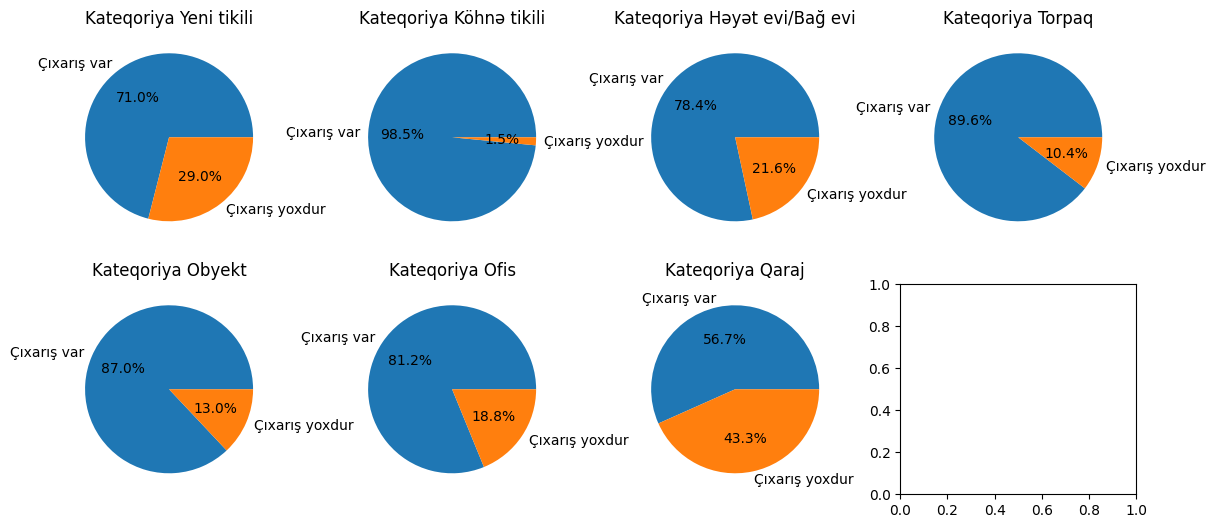

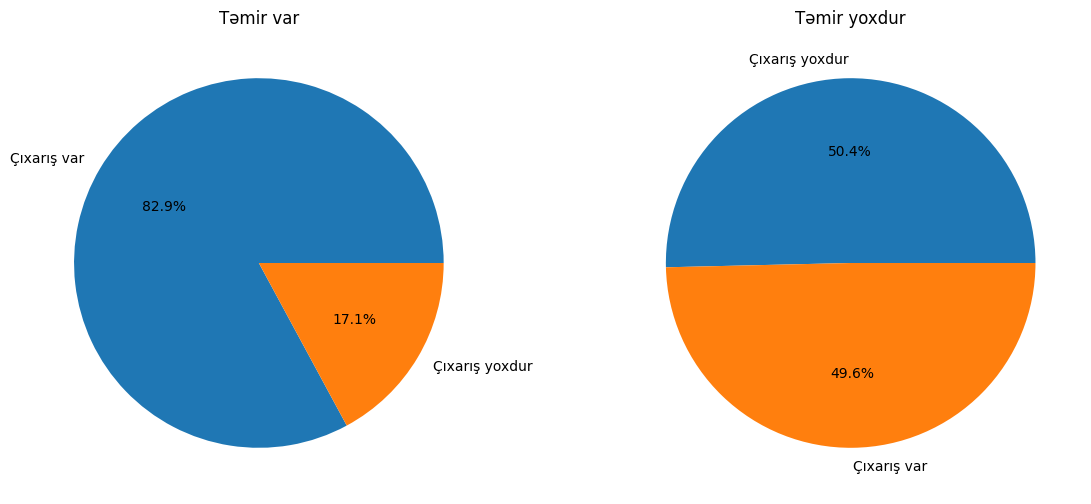

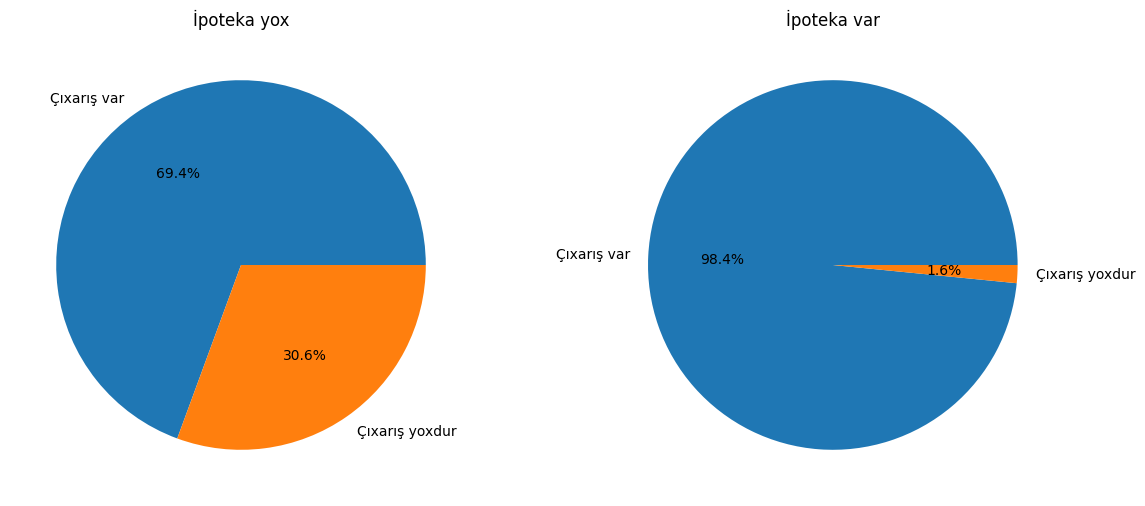

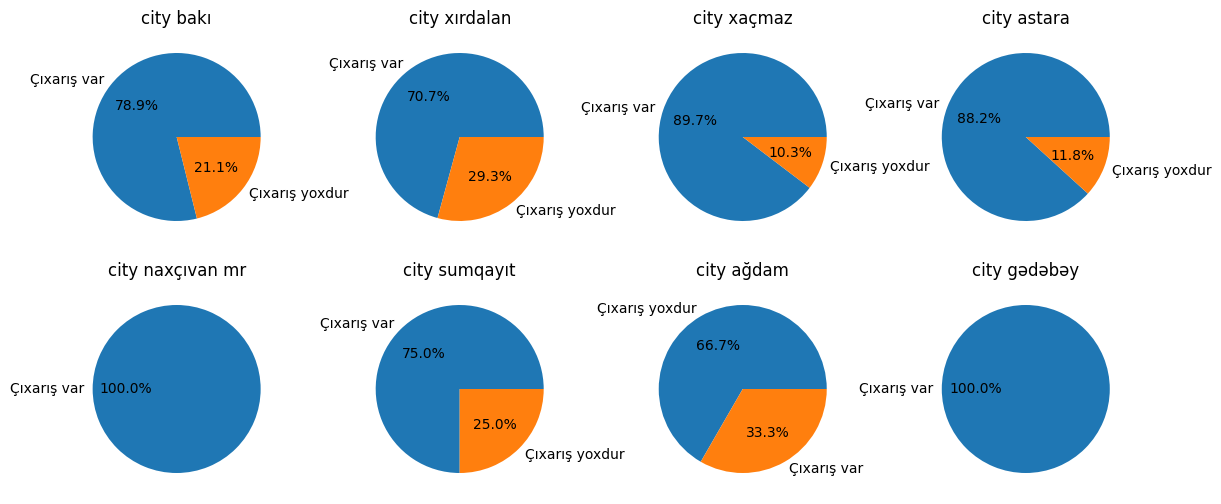

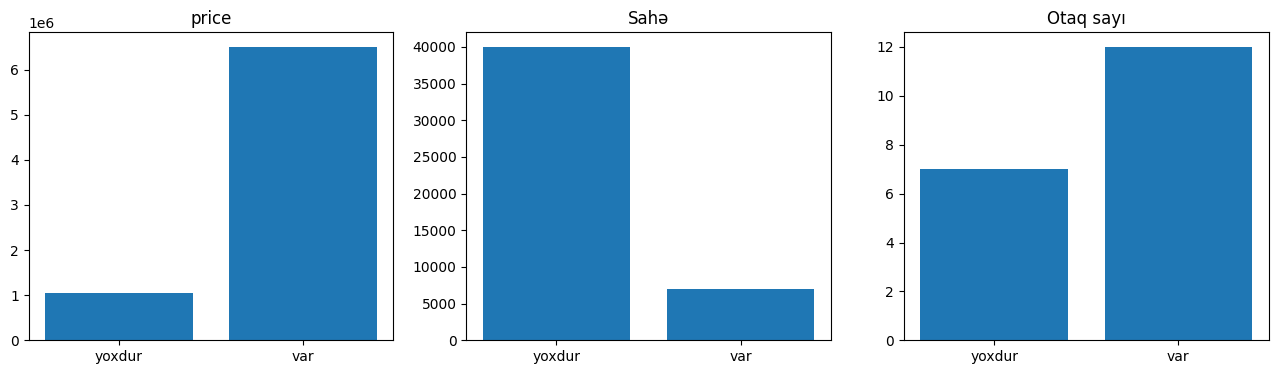

In [13]:
def creat_pie_plot(category=""):
    len_categoreis = len(data[category].value_counts().index)
    n_cols_categorie = round(len_categoreis / 2) if len_categoreis > 2 else 2
    n_rows_categorie = n_cols_categorie //2
    _, axes = plt.subplots(n_rows_categorie, n_cols_categorie, figsize=(14, 6))

    for axe, col in zip(axes.ravel(),data[category].value_counts().index):
        categorie_comb = data.loc[data[category] == col, [category, "Çıxarış"]]
        axe.pie(categorie_comb["Çıxarış"].value_counts().values, labels="Çıxarış " + categorie_comb["Çıxarış"].value_counts().index, autopct='%1.1f%%')
        axe.set_title(f"{category} {categorie_comb[category].values[0]}")
    

columns = ["price", "Sahə", "Otaq sayı","Kateqoriya", "Təmir", "İpoteka", "city"]


for item in columns[3:]:
    creat_pie_plot(category=item)

columns = ["price", "Sahə", "Otaq sayı"]

_, axes = plt.subplots(1, 3, figsize=(16, 4))

for axe, item in zip(axes.ravel(), columns):
    axe.bar(data["Çıxarış"][:1000], data[item][:1000])
    axe.set_title(item)



In [14]:
data.drop(index=data.loc[data["lng"] == data["lng"].min()].index, inplace=True)

In [35]:
from shapely.geometry import Point
import geopandas as gpd

geometry = [Point(xy) for xy in zip(data["lng"] ,data["lat"])]
    
gdf_points = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326")


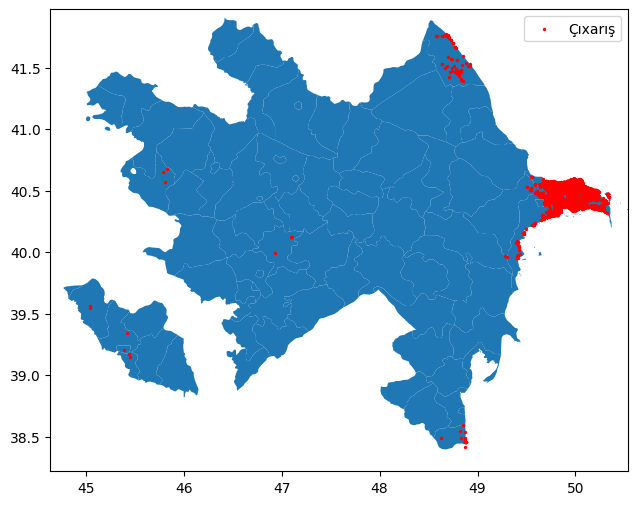

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
gdf = gpd.read_file(path/"gadm41_AZE_2.shx")
gdf.set_crs(epsg=4326)

gdf.plot(ax=ax)

gdf_points.plot(ax=ax, color="red", markersize=2, label="Çıxarış")
ax.set_xlim(data["lng"].min()-0.4, data["lng"].max()+0.2)
ax.set_ylim(data["lat"].min()-0.2, data["lat"].max()+0.2)
ax.legend()

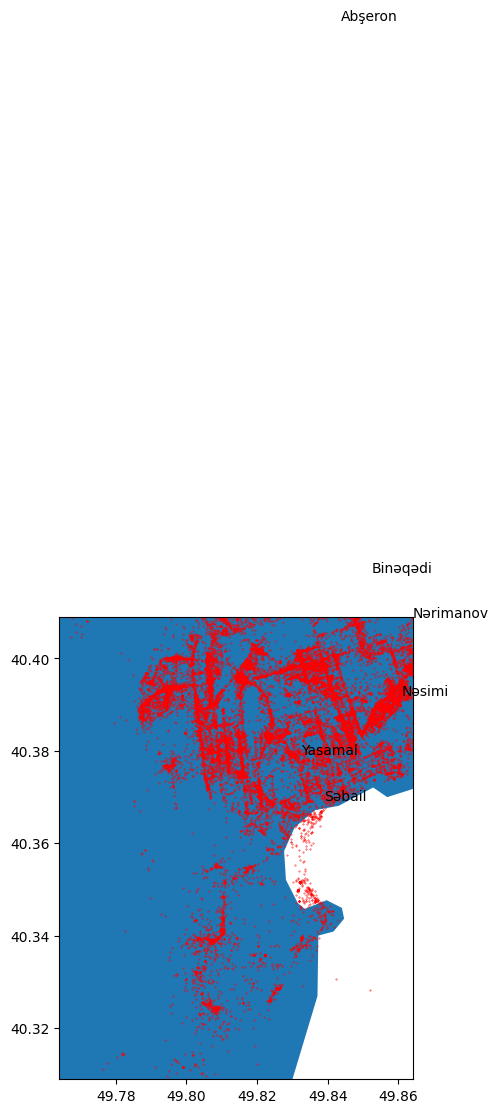

In [144]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
geolocator = Nominatim(user_agent="geoapi")

fig, ax = plt.subplots(figsize=(14, 6))

gdf.plot(ax=ax)
gdf_points.plot(ax=ax, color="red", markersize=0.1, label="Çıxarış")
max_x = data["lng"].value_counts().index[0]
min_x = max_x - 0.1

max_y = data["lat"].value_counts().index[0]
min_y = max_y - 0.1
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
locations = []

cord = data.loc[(data["lng"] <= max_x) & (data["lng"] >= min_x), ["lng", "lat"]].sort_values(by="lng", ascending=False)
lng_values = cord.loc[::400, "lng"]
lat_values = cord.loc[::400, "lat"]
for lng, lat in zip(lng_values[:50], lat_values[:50]):
    try:
        address = geolocator.reverse((lat, lng), exactly_one=True)
        parse_address = address.address.split(" ")
        address = " ".join(parse_address[parse_address.index("rayonu,")-1:parse_address.index("rayonu,")])
        if address not in locations:
            ax.text(lng, lat, address)
            locations.append(address)
            
    except GeocoderTimedOut as err:
        pass


## Base Line Model

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, penalty=None, learning_rate="optimal", loss="hinge")
sgd_clf.fit(X,y)
y_pred = sgd_clf.predict(X_test)
sgd_clf.score(X_test, y_test)

0.805812690696592

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

precision, recall

(0.5486247544204322, 0.5381835702240424)

In [18]:
cross_val_score(sgd_clf, X, y,cv=5, scoring="f1")

array([0.41676261, 0.56119963, 0.49614917, 0.53627285, 0.4931672 ])

In [104]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [105]:
pred_y = log_reg.predict(X_test)

In [106]:
y_test = y_test == 0 
precision_score(y_test, pred_y), recall_score(y_test, pred_y)


(0.6495071193866374, 0.2857142857142857)

In [87]:
(pred_y == True).sum(), (pred_y == False).sum()

(np.int64(17500), np.int64(1837))

In [93]:
(y_test == True).sum(), (y_test == False).sum()

(np.int64(15186), np.int64(4151))

In [ ]:
y_test

36130     True
61320     True
97843     True
55424     True
40197     True
         ...  
61492    False
45647     True
82518     True
1548     False
99877     True
Name: Çıxarış, Length: 19337, dtype: bool

In [107]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, pred_y)

array([[14546,   640],
       [ 2965,  1186]])

In [101]:
((4151+1837) / ((1837 + 15186)+ (4151+1837)))

0.26022337143105473

In [102]:
0.26022337143105473+0.8307428571428571


1.090966228573912

In [28]:
cross_val_score(log_reg, X, y, cv=10, scoring="f1")

array([0.37314198, 0.42650722, 0.40434333, 0.40471311, 0.41718976,
       0.42719432, 0.39029323, 0.41271443, 0.40723982, 0.44994944])

array([[ 1189,  2962],
       [  648, 14538]])

## Best Performed Model

In [33]:
from sklearn.svm import LinearSVC
lin_svc = LinearSVC()
lin_svc.fit(X_train, y_train)
y_pred_new = lin_svc.predict(X_test)

In [36]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred_new)
recall = recall_score(y_test, y_pred_new)

precision, recall

(0.657331136738056, 0.28836424957841483)

In [46]:
cross_val_score(lin_svc, X, y,cv=5, scoring="f1")

array([0.39673219, 0.40569948, 0.41360061, 0.38678027, 0.40497796])

# Clustering

In [ ]:
# I cannot compleate clustering problem